# Import Statements and Mount Drive

In [ ]:
!pip install datasets --quiet
!pip install evaluate --quiet
!pip install rouge_score --quiet
!pip install accelerate -U --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 2.7 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import DataCollatorForSeq2Seq
import evaluate
import numpy as np
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import pipeline
from transformers import TrainingArguments, Trainer, logging
from accelerate import Accelerator
from transformers import AutoProcessor
from transformers import AutoModelForCausalLM
import torch
from torch.utils.data import DataLoader
import os
from PIL import Image
import json

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = r"/content/drive/MyDrive/LLM Project/Formatted_Data"
dataset = load_dataset(dataset_path)
test_ds, val_ds, train_ds = dataset['test'], dataset['validation'], dataset['train']

Resolving data files:   0%|          | 0/6066 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/759 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/760 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

# BLIP Model Prompt Engineering Experimentation

In [ ]:
processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

In [ ]:
from torch.utils.data import Dataset

class PoemDataset(Dataset):
  #initialize
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  #need this function for the dataloader
  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    enc = self.processor(images=item["image"], text=item["text"], padding="max_length",max_length=512, return_tensors="pt")

    # remove batch dimension
    enc = {k:v.squeeze() for k,v in enc.items()}
    return enc

In [ ]:
train_dataset = PoemDataset(train_ds, processor)
val_dataset = PoemDataset(val_ds,processor)
test_dataset = PoemDataset(test_ds,processor)

In [ ]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=20)
val_dataloader = DataLoader(val_dataset,shuffle = True, batch_size = 20)

In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items(): print(k,v.shape)

pixel_values torch.Size([20, 3, 224, 224])
input_ids torch.Size([20, 512])
attention_mask torch.Size([20, 512])


In [ ]:
from transformers import Blip2Processor, Blip2ForConditionalGeneration # QuantoConfig
# from transformers.quantization import BitsAndBytesConfig

#quantization_config = QuantoConfig(weights="int8")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b") #quantization_config=quantization_config

config.json:   0%|          | 0.00/6.96k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/127k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/5.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
test_path = r"/content/drive/MyDrive/LLM Project/Formatted_Data/test"
train_path = r"/content/drive/MyDrive/LLM Project/Formatted_Data/train"

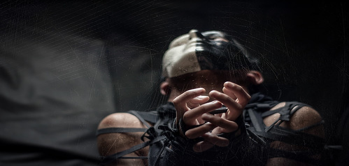

 spider man



In [ ]:
#load in image
image = os.listdir(train_path)[3]
image_path = os.path.join(train_path, image)
image = Image.open(image_path)

#resize image for better display
width, height = image.size
display(image.resize((int(0.7*width), int(0.5*height))))

#perform some prompt engineering
prompt = "Create a poem based on the image. Poem:"
inputs = processor(images=image, text=prompt, return_tensors="pt")
gen_ids = model.generate(**inputs, max_length = 50)
gen_poem = processor.batch_decode(gen_ids)[0]
print(gen_poem)

# Microsoft GIT Base Poem Generation Samples with Formatting

In [ ]:
processor = AutoProcessor.from_pretrained("microsoft/git-base")

trained_model =  AutoModelForCausalLM.from_pretrained("microsoft/git-base")
trained_optimizer = torch.optim.AdamW(trained_model.parameters(), lr=5e-5)

# Load the model with optimizer state
trained_model.load_state_dict(torch.load(r'/content/drive/MyDrive/LLM Project/Microsoft_GIT_model_v1/finetuned_model_v1'))
trained_optimizer.load_state_dict(torch.load(r'/content/drive/MyDrive/LLM Project/Microsoft_GIT_model_v1/optimizer_state_v1'))

# evaluation mode for inference
trained_model.eval()

GitForCausalLM(
  (git): GitModel(
    (embeddings): GitEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(1024, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (image_encoder): GitVisionModel(
      (vision_model): GitVisionTransformer(
        (embeddings): GitVisionEmbeddings(
          (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
          (position_embedding): Embedding(197, 768)
        )
        (pre_layrnorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (encoder): GitVisionEncoder(
          (layers): ModuleList(
            (0-11): 12 x GitVisionEncoderLayer(
              (self_attn): GitVisionAttention(
                (k_proj): Linear(in_features=768, out_features=768, bias=True)
                (v_proj): Linear(in_features=768, out_features=768, bias=True)
             

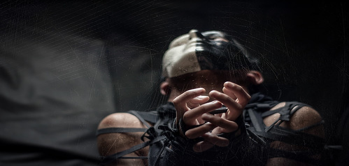

the world is so dark and dark and dark and dark and light and dark and dark and dark and light


In [ ]:
#load in image
image = os.listdir(train_path)[3]
image_path = os.path.join(train_path, image)
image = Image.open(image_path)

#resize image for better display
width, height = image.size
display(image.resize((int(0.7*width), int(0.5*height))))

#generate poem
inputs = processor(images=image, return_tensors="pt")
pixel_values = inputs.pixel_values
gen_ids = trained_model.generate(pixel_values=pixel_values, max_length=50)
gen_poem = processor.batch_decode(gen_ids, skip_special_tokens = True)[0]
print(gen_poem)

In [ ]:
def format_poem(poem, max_line_length):
  #max_line_length is max length for a line in the poem (based on characters)

  lines = []
  current_line = ""

  for word in poem.split():

    # Check if adding the next word exceeds the max line length
    if len(current_line) + len(word) + 1 <= max_line_length:
      #add word to the line
      current_line += word + " "

    else:
      lines.append(current_line.strip())
      current_line = word + " "

  # Add the last line to list
  if current_line:
    lines.append(current_line.strip())


  # join with newline chars
  formatted_poem = "\n".join(lines)


  return formatted_poem


formatted_poetry = format_poem(gen_poem, 30)
print(formatted_poetry)

the world is so dark and dark
and dark and dark and light
and dark and dark and dark
and light


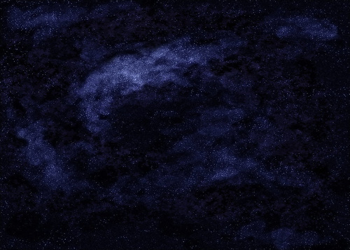

i am the star that i am the star that is the sky i am the star that i am the star that i am the star of the night and the sky i am the star of the moon
i am the star that i am
the star that is the sky
i am the star that i am
the star that i am the
star of the night and
the sky i am the star of
the moon


In [ ]:
#load in image
image = os.listdir(train_path)[10]
image_path = os.path.join(train_path, image)
image = Image.open(image_path)

#resize image for better display
width, height = image.size
display(image.resize((int(0.7*width), int(0.5*height))))

#generate poem
inputs = processor(images=image, return_tensors="pt")
pixel_values = inputs.pixel_values
gen_ids = trained_model.generate(pixel_values=pixel_values, max_length=50)
gen_poem = processor.batch_decode(gen_ids, skip_special_tokens = True)[0]
formatted_poetry = format_poem(gen_poem, 25)
print(gen_poem)
print(formatted_poetry)

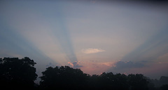

the light of the sun is
a light that shines
through the clouds


In [ ]:
#load in image
image = os.listdir(train_path)[50]
image_path = os.path.join(train_path, image)
image = Image.open(image_path)

#resize image for better display
width, height = image.size
display(image.resize((int(0.7*width), int(0.5*height))))

#generate poem
inputs = processor(images=image, return_tensors="pt")
pixel_values = inputs.pixel_values
gen_ids = trained_model.generate(pixel_values=pixel_values, max_length=50)
gen_poem = processor.batch_decode(gen_ids, skip_special_tokens = True)[0]
formatted_poetry = format_poem(gen_poem, 25)
print(formatted_poetry)

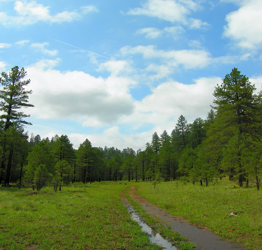

the path to the heaven
of the mountain and the
heaven of heaven


In [ ]:
#load in image
image = os.listdir(train_path)[33]
image_path = os.path.join(train_path, image)
image = Image.open(image_path)

#resize image for better display
width, height = image.size
display(image.resize((int(0.7*width), int(0.5*height))))

#generate poem
inputs = processor(images=image, return_tensors="pt")
pixel_values = inputs.pixel_values
gen_ids = trained_model.generate(pixel_values=pixel_values, max_length=50)
gen_poem = processor.batch_decode(gen_ids, skip_special_tokens = True)[0]
formatted_poetry = format_poem(gen_poem, 25)
print(formatted_poetry)

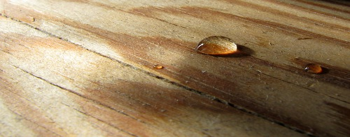

the heart of the soul is
a little silence but the
heart is a little
silence


In [ ]:
#load in image
image = os.listdir(train_path)[23]
image_path = os.path.join(train_path, image)
image = Image.open(image_path)

#resize image for better display
width, height = image.size
display(image.resize((int(0.7*width), int(0.5*height))))

#generate poem
inputs = processor(images=image, return_tensors="pt")
pixel_values = inputs.pixel_values
gen_ids = trained_model.generate(pixel_values=pixel_values, max_length=50)
gen_poem = processor.batch_decode(gen_ids, skip_special_tokens = True)[0]
formatted_poetry = format_poem(gen_poem, 25)
print(formatted_poetry)

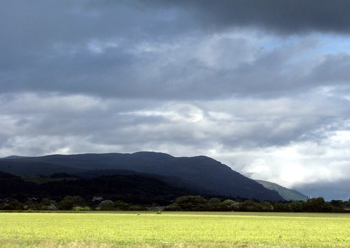

the sky is so dark and
the sun is shining
through the clouds the
sky is so dark and the
sun is shining bright
the sky is dark and the
clouds are dark and the
sky is dark is dark and
the clouds are dark and
the mountains are


In [ ]:
#load in image
image = os.listdir(train_path)[72]
image_path = os.path.join(train_path, image)
image = Image.open(image_path)

#resize image for better display
width, height = image.size
display(image.resize((int(0.7*width), int(0.5*height))))

#generate poem
inputs = processor(images=image, return_tensors="pt")
pixel_values = inputs.pixel_values
gen_ids = trained_model.generate(pixel_values=pixel_values, max_length=50)
gen_poem = processor.batch_decode(gen_ids, skip_special_tokens = True)[0]
formatted_poetry = format_poem(gen_poem, 25)
print(formatted_poetry)

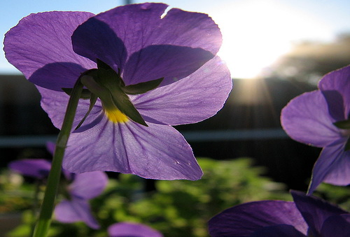

the violets the
bluebells are the purple
blue and the yellow
light is the sun


In [ ]:
#load in image
image = os.listdir(test_path)[50]
image_path = os.path.join(test_path, image)
image = Image.open(image_path)

#resize image for better display
width, height = image.size
display(image.resize((int(0.7*width), int(0.5*height))))

#generate poem
inputs = processor(images=image, return_tensors="pt")
pixel_values = inputs.pixel_values
gen_ids = trained_model.generate(pixel_values=pixel_values, max_length=50)
gen_poem = processor.batch_decode(gen_ids, skip_special_tokens = True)[0]
formatted_poetry = format_poem(gen_poem, 25)
print(formatted_poetry)

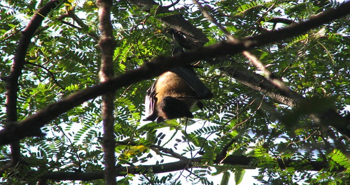

the sun is shining on
the ground the sun is
shining bright the day
is done and the light is
on is on the other side
and the light is on the
sky is dark and the
light is dark and the
sun is shining through
the trees are


In [ ]:
#load in image
image = os.listdir(test_path)[70]
image_path = os.path.join(test_path, image)
image = Image.open(image_path)

#resize image for better display
width, height = image.size
display(image.resize((int(0.7*width), int(0.5*height))))

#generated poem
inputs = processor(images=image, return_tensors="pt")
pixel_values = inputs.pixel_values
gen_ids = trained_model.generate(pixel_values=pixel_values, max_length=50)
gen_poem = processor.batch_decode(gen_ids, skip_special_tokens = True)[0]
formatted_poetry = format_poem(gen_poem, 25)
print(formatted_poetry)

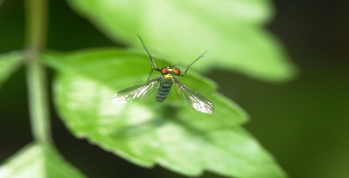

i am a fly i am a fly i
am a fly i am a fly i am
a fly i am a fly i am a
fly i am a fly i am a
fly i am a man i am a
man i am a man i


In [ ]:
#load in image
image = os.listdir(test_path)[23]
image_path = os.path.join(test_path, image)
image = Image.open(image_path)

#resize image for better display
width, height = image.size
display(image.resize((int(0.7*width), int(0.5*height))))

#generate poem
inputs = processor(images=image, return_tensors="pt")
pixel_values = inputs.pixel_values
gen_ids = trained_model.generate(pixel_values=pixel_values, max_length=50)
gen_poem = processor.batch_decode(gen_ids, skip_special_tokens = True)[0]
formatted_poetry = format_poem(gen_poem, 25)
print(formatted_poetry)

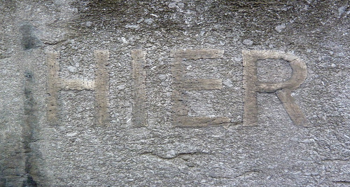

i'm not sure of you but
you're not just a stone
but you're not a man


In [ ]:
#load in image
image = os.listdir(test_path)[60]
image_path = os.path.join(test_path, image)
image = Image.open(image_path)

#resize image for better display
width, height = image.size
display(image.resize((int(0.7*width), int(0.5*height))))

#generate poem
inputs = processor(images=image, return_tensors="pt")
pixel_values = inputs.pixel_values
gen_ids = trained_model.generate(pixel_values=pixel_values, max_length=50)
gen_poem = processor.batch_decode(gen_ids, skip_special_tokens = True)[0]
formatted_poetry = format_poem(gen_poem, 25)
print(formatted_poetry)

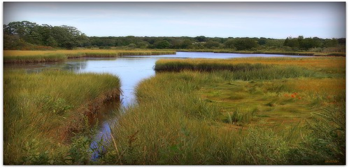

the river flows through
the fields of gold and
silver where the river
flows through the valley
of the valley where the
river flows through the
trees and the river
flows through the valley
beneath the trees


In [ ]:
#load in image
image = os.listdir(test_path)[74]
image_path = os.path.join(test_path, image)
image = Image.open(image_path)

#resize image for better display
width, height = image.size
display(image.resize((int(0.7*width), int(0.5*height))))

#generate poem
inputs = processor(images=image, return_tensors="pt")
pixel_values = inputs.pixel_values
gen_ids = trained_model.generate(pixel_values=pixel_values, max_length=50)
gen_poem = processor.batch_decode(gen_ids, skip_special_tokens = True)[0]
formatted_poetry = format_poem(gen_poem, 25)
print(formatted_poetry)

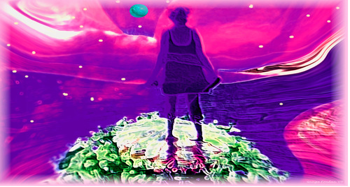

i've been wanting to be
a dream for a moment to
be a dream of a dream
i've been a dream i've
been a dream i've been a
dream i'm a dream of a
dream i'm a


In [ ]:
#load in image
image = os.listdir(test_path)[13]
image_path = os.path.join(test_path, image)
image = Image.open(image_path)

#resize image for better display
width, height = image.size
display(image.resize((int(0.7*width), int(0.5*height))))

#generate poem
inputs = processor(images=image, return_tensors="pt")
pixel_values = inputs.pixel_values
gen_ids = trained_model.generate(pixel_values=pixel_values, max_length=50)
gen_poem = processor.batch_decode(gen_ids, skip_special_tokens = True)[0]
formatted_poetry = format_poem(gen_poem, 25)
print(formatted_poetry)

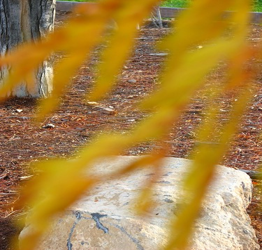

the life of a life is a
journey that never stops
at all and all


In [ ]:
#load in image
image = os.listdir(test_path)[15]
image_path = os.path.join(test_path, image)
image = Image.open(image_path)

#resize image for better display
width, height = image.size
display(image.resize((int(0.7*width), int(0.5*height))))

#generated poem
inputs = processor(images=image, return_tensors="pt")
pixel_values = inputs.pixel_values
gen_ids = trained_model.generate(pixel_values=pixel_values, max_length=50)
gen_poem = processor.batch_decode(gen_ids, skip_special_tokens = True)[0]
formatted_poetry = format_poem(gen_poem, 25)
print(formatted_poetry)